In [1]:
from Pointcloud.Modules.Object import Pointcloud
from Pointcloud.Modules.Processor import Processor
from Pointcloud.Modules.Utils import TorchUtils

import torch
from tqdm import tqdm
import meshplot as mp
import matplotlib.pyplot as plt

objectname = "common-3d-test-models-master/fandisk.obj"
# objectname = "common-3d-test-models-master/ogre.obj"
# objectname = "cube.obj"
# objectname = "sphere.obj"

In [2]:
gt_pc = Pointcloud.sampleObj(objectname, 2 ** 16)
gt_pp = Processor(gt_pc)

sample_pc = Pointcloud.sampleObj(objectname, 2 ** 14)
sample_pp = Processor(sample_pc)

In [3]:
gt_pos = gt_pp.graph.pos
noisy_pos = sample_pp.graph.pos

radius = TorchUtils.pointcloudRadius(noisy_pos)

cd = TorchUtils.ChamferDistance(gt_pos, noisy_pos)
hd = TorchUtils.HausdorffDistance(gt_pos, noisy_pos)
pd = TorchUtils.PaperDistance(gt_pos, noisy_pos)

print(cd.mean(dim=0), hd.max(dim=0).values, pd.mean(dim=0))

# plot = mp.plot(noisy_pos.numpy(), c=cd[:noisy_pos.shape[0]].numpy(), shading={"point_size": radius / 6})
# plot = mp.plot(noisy_pos.numpy(), c=hd[:noisy_pos.shape[0]].numpy(), shading={"point_size": radius / 6})
# plot = mp.plot(noisy_pos.numpy(), c=pd[:noisy_pos.shape[0]].numpy(), shading={"point_size": radius / 6})

tensor(0.0010) tensor(0.1207) tensor(0.0020)


In [4]:
k = 12
noise_level = 0.3

_graph = sample_pp.graph
_graphBuilder = sample_pp.graphBuilder
_noise = sample_pp.noise

_graph.edge_index = _graphBuilder.getKNNEdgeIndex(k)
_graphBuilder.setAndFlipNormals(flip=False)

_pos = _graph.pos
_edge_index = _graph.edge_index

l = TorchUtils.averageEdgeLength(_pos, _edge_index)
_noise.generateNoise(noise_level, l, keepNormals=False)
_graphBuilder.setAndFlipNormals(flip=True)

Creating MST..: 100%|██████████| 196608/196608 [00:06<00:00, 32607.88it/s]


In [5]:
_graph = sample_pp.graph
_pos = _graph.pos
_n = _graph.n

plot = mp.plot(_pos.numpy(), shading={"point_size": radius / 8})
_ = plot.add_lines(_pos.numpy(), (_pos + 2 * l * _n).numpy(), shading={"line_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4024957…

In [6]:
################################
##   Decomposition Detailed   ##
################################

noisy_graph_pos = sample_pp.graph.pos.clone()
N = noisy_graph_pos.size(0)
r = (2 * 64 / k) ** 0.5 * l
d = 2 * l

_graphBuilder = sample_pp.graphBuilder
_selector = sample_pp.selector
_alignor = sample_pp.alignor
_graph = sample_pp.graph

selection = _selector.getPointsInRangeSelection(r)
filtered_n = _alignor.getVUFilteredNormals(selection)
_graph.edge_index = _graphBuilder.getKNNEdgeIndex(64)
edge_vectors = _graphBuilder.getPVTDecompositionWithKNN(_graph.edge_index)

def NVT(bindex: torch.Tensor, weight: torch.Tensor, vector: torch.Tensor):
    _device = weight.device
    # (P, 3, 3)
    outer = vector[..., None] * vector[:, None]
    # (N, P, 3, 3)
    Tj = weight[..., None, None] * outer
    # (I, 3, 3)
    return torch.zeros((bindex.max(dim=0).values + 1, 3, 3), dtype=Tj.dtype, device=_device) \
                .index_add_(dim=0, index=bindex, source=Tj)

rho = 0.9
_n = filtered_n

_g = _graph
_data = selection.data
_device = _data.device
_dtype_ints = _data.dtype
I = len(selection)
bindex = selection._batchIndices()[0]
_v = _g.pos
_dtype_floats = _v.dtype

vj = _v[_data]
ni = _n[bindex]
nj = _n[_data]
wij = ((ni * nj).sum(dim=1).clamp_(-1, 1).acos_() <= rho).to(_dtype_ints)
wvij = wij[..., None] * vj
summed_wij = torch.zeros((I,), dtype=_dtype_ints, device=_device) \
    .index_add_(dim=0, index=bindex, source=wij)
summed_wvij = torch.zeros((I, 3), dtype=_dtype_floats, device=_device) \
    .index_add_(dim=0, index=bindex, source=wvij)
v_center = summed_wvij / summed_wij[:, None]
dv = vj - v_center[bindex]
summed_wdv = NVT(bindex, wij, dv)
Ci = summed_wdv / summed_wij[:, None, None]
eigval, eigvec = torch.linalg.eigh(Ci)
ordered_eigval = eigval.sort(dim=1, descending=True)
batch_idx = torch.arange(I, device=_device)[:, None]
ordered_eigvec = eigvec[batch_idx, :, ordered_eigval.indices].transpose(1, 2)
eigval, eigvec = ordered_eigval.values, ordered_eigvec
features = _alignor.getVUFeatures(eigval, l, k)


In [7]:
color = features
plot = mp.plot(_graph.pos.numpy(), c=color.numpy(), shading={"point_size": radius / 6})
_ = plot.add_lines(_graph.pos.numpy(), noisy_graph_pos.numpy())
e = edge_vectors.clone()
e[features < 2] = 0
# _ = plot.add_lines(_graph.pos.numpy(), (_graph.pos + e[:, 0] * l * 2).numpy(), shading={"line_color": "blue"})
# _ = plot.add_lines(_graph.pos.numpy(), (_graph.pos + e[:, 1] * l * 2).numpy(), shading={"line_color": "red"})
_ = plot.add_lines(_graph.pos.numpy(), (_graph.pos + e[..., 2] * l * 2).numpy(), shading={"line_color": "green"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4024957…

In [8]:
noisy_graph_pos = sample_pp.graph.pos.clone()
noisy_graph_n = sample_pp.graph.n.clone()
N = sample_pp.graph.num_nodes
r = (2 * 64 / k) ** 0.5 * l
d = 2 * l

_selector = sample_pp.selector
_alignor = sample_pp.alignor
_graph = sample_pp.graph
_denoiser = sample_pp.denoiser

initial_size = TorchUtils.pointcloudRadius(noisy_graph_pos)

# Do step
M = 16
errors = torch.zeros((M + 1,))
pos_video = torch.zeros((M + 1, N, 3))
pos_video[0] = noisy_graph_pos
errors[0] = TorchUtils.PaperDistance(gt_pp.graph.pos, _graph.pos).mean(dim=0)
for i in tqdm(range(M), desc="Running vertex updating steps"):
    _graph.edge_index = _graphBuilder.getKNNEdgeIndex(k)
    decomposition = _graphBuilder.getPVTDecompositionWithKNN(_graph.edge_index)
    edge_vectors = decomposition[..., 2]
    selection = _selector.getPointsInRangeSelection(r)
    filtered_n = _alignor.getVUFilteredNormals(selection)
    # filtered_n = _graph.n
    eigval, eigvec = _alignor.getVUDecomposition(selection, filtered_n)
    # edge_vectors = eigvec[:, 0]
    features = _alignor.getVUFeatures(eigval, l, k)
    corners = (features == 0).nonzero().flatten()
    edges = (features == 2).nonzero().flatten()
    flats = (features == 1).nonzero().flatten()
    # non_flats = (features < 3).nonzero().flatten()
    corner_pos = _denoiser.corner_step(corners, selection, filtered_n, d)
    edge_pos = _denoiser.edge_step(edges, selection, filtered_n, edge_vectors, d)
    flat_pos = _denoiser.flat_step(flats, selection, filtered_n, d)
    # feature_pos, _ = _denoiser.feature_step(non_flats, selection, filtered_n)
    _graph.pos[corners] = corner_pos
    _graph.pos[edges] = edge_pos
    _graph.pos[flats] = flat_pos
    # _graph.pos[non_flats] = feature_pos
    # _graph.pos = _graph.pos * (initial_size / TorchUtils.pointcloudRadius(_graph.pos))
    # Calculate error
    error = TorchUtils.PaperDistance(gt_pp.graph.pos, _graph.pos).mean(dim=0)
    errors[i+1] = error
    # Save video
    pos_video[i+1] = _graph.pos

Running vertex updating steps:  25%|██▌       | 4/16 [00:08<00:24,  2.07s/it]


_LinAlgError: torch.linalg.eigh: (Batch element 1700): The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 2).

In [9]:
######################
## Error evaluation ##
######################

# Filtering normals works again with larger knn neighbourhood
# However when a normal is so out of line with all its neighbours,
# Isn't the normal itself wrong?
# Next time: find normals where the majority disagrees with the direction
# of the normal of the point. If so, isolate them, visualize them,
# check if they are calculated in the right way and if needed,
# recalculate the normal, because it fucking sucks
edge_indices = (features == 2).nonzero().flatten()
random_index = edge_indices[torch.randperm(edge_indices.size(0))[0]]
# random_index = torch.tensor(5021)
v_random = _g.pos[random_index]
neighbour_indices = _g.edge_index[1][_g.edge_index[0] == random_index]
j = torch.cat([random_index[None], neighbour_indices])
vj = _g.pos[j]
angles = (_g.n[_g.edge_index[0]] * _g.n[_g.edge_index[1]]).sum(dim=1)
q1 = angles.quantile(0.25)
q3 = angles.quantile(0.75)
threshold = q1 - (q3 - q1) * 1.5
print(f"Outlier percentage: {(angles < threshold).nonzero().size(0) / _g.num_edges * 100} with threshold: {threshold}")
print(f"Neighbourhood indices: {j}")
print(f"Broken point distance travelled: {(noisy_graph_pos[random_index] - v_random).norm(dim=0)}")
normal_angles = (_g.n[j] * _g.n[random_index][None]).sum(dim=1)
c = normal_angles >= 0.9
plot = mp.plot(vj.numpy(), c=c.numpy(), shading={"point_size": l})
_ = plot.add_lines(v_random[None][torch.zeros_like(j)].numpy(), vj.numpy())
_ = plot.add_lines(vj.numpy(), (vj + filtered_n[j] * l * 0.5).numpy())
_ = plot.add_lines(v_random.numpy(), (v_random + filtered_n[random_index] * l).numpy(), shading={"line_color": "red"})
_ = plot.add_lines(v_random.numpy(), (v_random + eigvec[random_index, 0] * l * 2).numpy(), shading={"line_color": "blue"})
c2 = torch.zeros((_g.num_nodes,))
c2[j] = 1
plot_whole = mp.plot(_g.pos.numpy(), c=c2.numpy(), shading={"point_size": l * 5})
_ = plot_whole.add_lines(noisy_graph_pos[random_index].numpy(), v_random.numpy())
_ = plot_whole.add_lines(v_random.numpy(), (v_random + _g.n[random_index] * l * 2).numpy(), shading={"line_color": "red"})
# _ = plt.hist(angles, 50)

Outlier percentage: 13.14670518584827 with threshold: 0.7790334224700928
Neighbourhood indices: tensor([ 5428, 12481, 10089,  7524,  4918, 15743, 15260, 14212, 14041,  7755,
        14685,  8879, 10780])
Broken point distance travelled: 0.10066040605306625


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5994960…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4177542…

tensor(0.6337)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4177542…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.3753376…

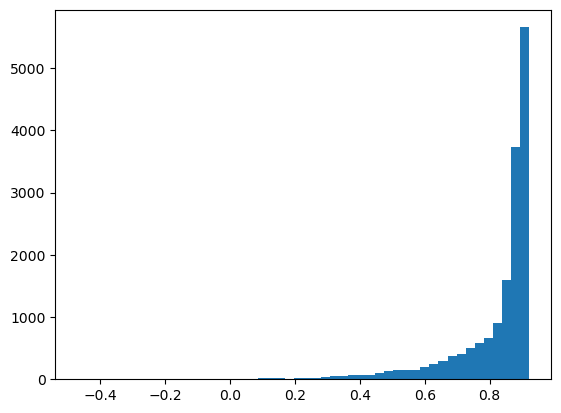

In [10]:
# Init variables
_graph = sample_pp.graph
N = _graph.num_nodes
E = _graph.num_edges
_pos = _graph.pos
_edge_index = _graph.edge_index
_n = _graph.n
i, j = _edge_index
l = TorchUtils.averageEdgeLength(_pos, _edge_index)

# Do the angle calculations
angles = (_n[i] * _n[j]).sum(dim=1)
meaned = torch.zeros((N,), dtype=torch.float32) \
    .index_reduce_(dim=0, index=i, source=angles.to(torch.float32), reduce="mean")

lower_threshold = (meaned.quantile(0.75) * (-1.5) + meaned.quantile(0.25) * (2.5))
# lower_threshold = 0.75
error_indices = (meaned < lower_threshold).nonzero().flatten()

# Print stuff
# print(meaned.unique(return_counts=True))
print(meaned.quantile(0.75) * (-1.5) + meaned.quantile(0.25) * (2.5))

# Plot stuff
_ = plt.hist(meaned, 50)

# 3D Plot error indices and their normals
plot = mp.plot(
    _pos.numpy(),
    c=(meaned < lower_threshold).numpy(),
    shading={"point_size": 5 * l}
)
_ = plot.add_lines(
    _pos[error_indices].numpy(),
    (_pos[error_indices] + _n[error_indices] * l).numpy()
)

example_error_index = error_indices[torch.randperm(error_indices.size(0))[0]]
neighbour_edges = i == example_error_index
neighbour_indices = j[neighbour_edges]
plot = mp.plot(
    _pos[torch.cat([example_error_index[None], neighbour_indices])].numpy(),
    c=torch.cat([torch.tensor([1]), angles[neighbour_edges]]).numpy(),
    shading={"point_size": l}
)
_ = plot.add_lines(
    _pos[neighbour_indices].numpy(),
    (_pos[neighbour_indices] + _n[neighbour_indices] * l * 0.5).numpy()
)
_ = plot.add_lines(
    _pos[example_error_index].numpy(),
    (_pos[example_error_index] + _n[example_error_index] * l).numpy(),
    shading={"line_color": "red"}
)

Error was lowest at 6 with 0.002839687978848815
Showing iterations: [0, 1, tensor(6), tensor(6)]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4068164…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4084711…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4177542…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4177542…

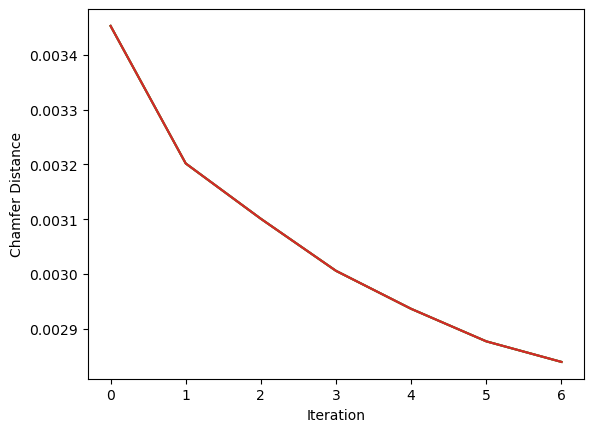

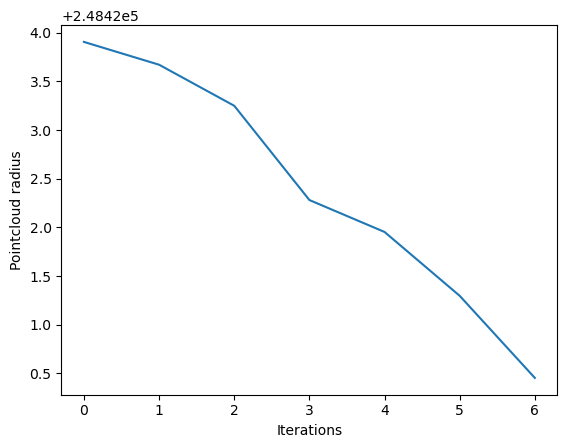

In [11]:
# Print stuff
min_error_i = errors[errors > 0].argmin(dim=0)
print(f"Error was lowest at {min_error_i} with {errors[min_error_i]}")

# Plot stuff
indices = [0, 1, min_error_i, torch.cat([torch.tensor(errors.size(0))[None], (errors == 0).nonzero().flatten()]).min() - 1]
print(f"Showing iterations: {indices}")
for i in indices:
    pos_to_plot = pos_video[i]
    plt.xlabel("Iteration")
    plt.ylabel("Chamfer Distance")
    plot = plt.plot(errors[errors > 0])
    # _ = visGraphs([_graph, sample_gb.graph])
    # color = (_graph.pos - noisy_graph_pos).norm(dim=1)
    color = (pos_to_plot - noisy_graph_pos).norm(dim=1)
    if i == 0:
        color = features
    plot = mp.plot(pos_to_plot.numpy(), c=color.numpy(), shading={"point_size": radius / 6})
    _ = plot.add_lines(pos_to_plot.numpy(), noisy_graph_pos.numpy())

# e = eigvec[:, 0, :].clone()
# e[features < 2, :] = 0
# _ = plot.add_lines(_graph.pos.numpy(), (_graph.pos + e * l * 2).numpy(), shading={"line_color": "blue"})
# _ = plot.add_lines(_graph.pos.numpy(), (_graph.pos + _n * l).numpy(), shading={"line_color": "red"})
plt.figure()
centers = pos_video.sum(dim=1, keepdim=True)
_ = plt.plot((pos_video - centers).norm(dim=2).max(dim=1).values[errors > 0].numpy())
_ = plt.xlabel("Iterations")
_ = plt.ylabel("Pointcloud radius")

In [12]:
color = torch.zeros((2*N,))
color[:N] = 1
mp.plot(torch.cat([pos_video[0], pos_video[16]]).numpy(), c=color.numpy(), shading={"point_size": 3*l})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4068164…